## Shopify Data Science Challenge Problems:


#### *Please view the notebook in NBviewer to see all the plotly graphs of this notebook

#### Question 1: Given some sample data, write a program to answer the following:

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

1. Think about what could be going wrong with our calculation. 
2. Think about a better way to evaluate this data. 
3. What metric would you report for this dataset?
4. What is its value?




#### Question 2:

For this question you’ll need to use SQL. Follow this link: https://www.w3schools.com/SQL/TRYSQL.ASP?FILENAME=TRYSQL_SELECT_ALL to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.
1. How many orders were shipped by Speedy Express in total?
2. What is the last name of the employee with the most orders?¶
3. What product was ordered the most by customers in Germany?¶

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shopify-data-science-internship-challenge/Shopify.csv


In [2]:
df = pd.read_csv("../input/shopify-data-science-internship-challenge/Shopify.csv")
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


## Doing basic data exploration

In [3]:
df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


1. Clearly the mean order amount is 3145.13 which is way too high for a sneaker store -> This indicates that some stores or some users might be associated with fraud (outliers)
2. The median on the other hand is 284 which is much more reasonable and the actual mean should lie between those 2

In [4]:
df.info() # we can safely proceed as there are no nulls in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


In [6]:
duplicateRows = df[df.duplicated()]
duplicateRows

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at


There are no missing values or duplicates in order id. Our dataset is clean and we can proceed

In [7]:
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [8]:
df['shop_id'].nunique()

100

In [9]:
df['shop_id'].value_counts()

53    68
71    66
19    64
13    63
89    61
      ..
74    38
56    37
67    37
38    35
85    35
Name: shop_id, Length: 100, dtype: int64

In [10]:
df['order_amount'].value_counts()

153     87
306     85
354     82
312     75
156     75
        ..
774      1
786      1
725      1
1086     1
816      1
Name: order_amount, Length: 258, dtype: int64

<AxesSubplot:xlabel='order_amount', ylabel='Count'>

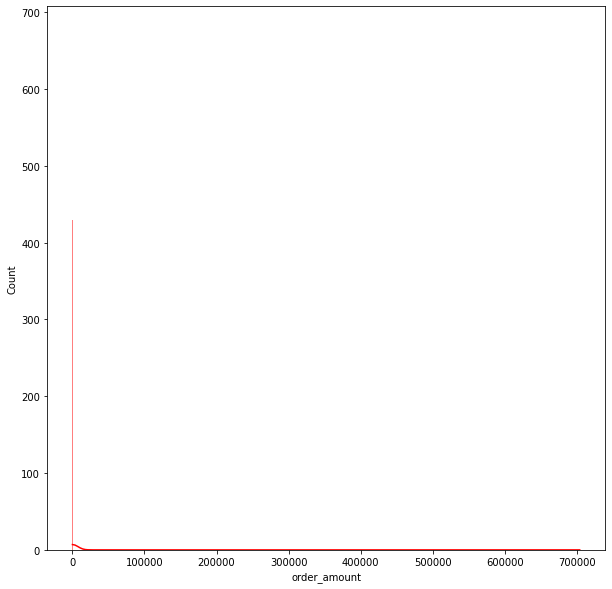

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
sns.histplot(df['order_amount'], color='red', kde=True)

In [13]:
df['user_id'].value_counts()

718    28
868    27
847    26
791    26
786    25
       ..
998     9
812     9
902     9
717     7
750     7
Name: user_id, Length: 301, dtype: int64

In [14]:
df['user_id'].nunique()

301

<AxesSubplot:xlabel='shop_id'>

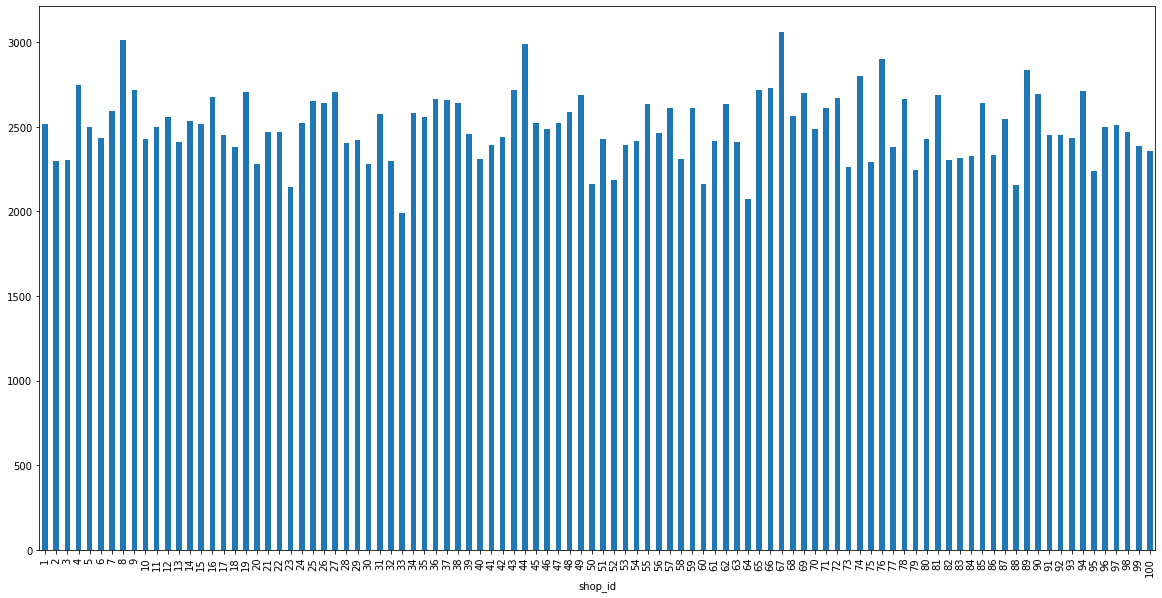

In [15]:
df_group_shop = df.groupby('shop_id')['order_id'].mean()
df_group_shop.plot.bar(figsize=(20,10))

Both median and mean of shops have pretty normal distribution, we would have to dig deeper to find outliers

<AxesSubplot:xlabel='shop_id'>

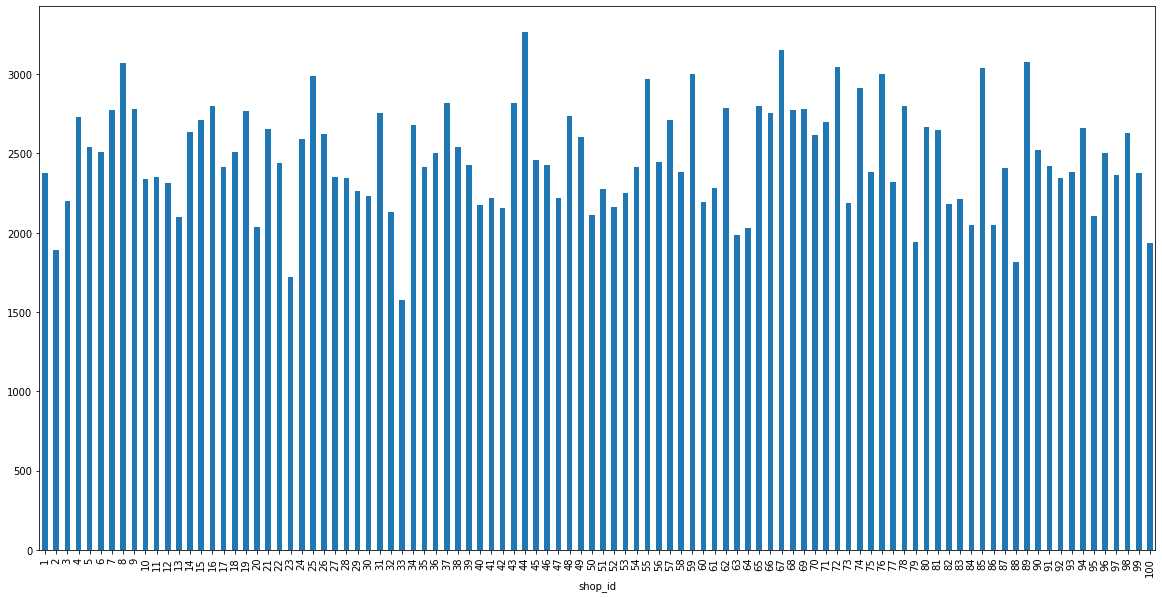

In [16]:
df_group_shop = df.groupby('shop_id')['order_id'].median()
df_group_shop.plot.bar(figsize=(20,10))

In [17]:
df_group_user = pd.DataFrame({'mean_amount': df.groupby('user_id')['order_amount'].mean()}).reset_index()
df_group_user

,user_id,mean_amount
0,607,704000.000000
1,700,299.375000
2,701,397.076923
3,702,406.615385
4,703,380.687500
...,...,...
296,995,354.400000
297,996,252.952381
298,997,2248.923077
299,998,291.111111


<BarContainer object of 36 artists>

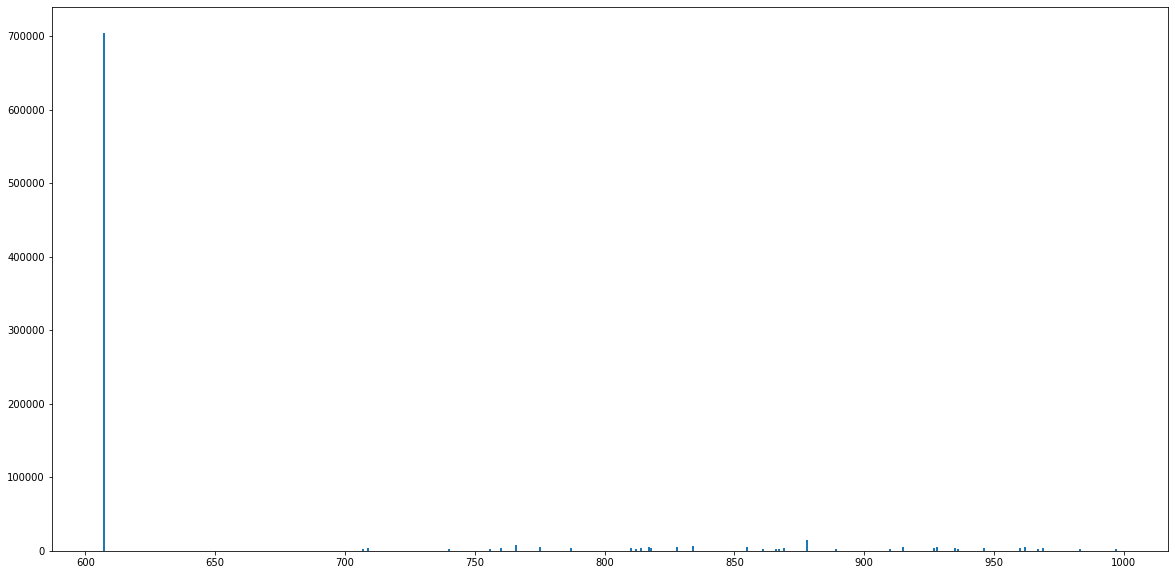

In [18]:
subset_df = df_group_user[df_group_user['mean_amount']>2000]
#subset_df
fig = plt.figure(figsize=(20,10))
plt.bar(subset_df['user_id'], subset_df['mean_amount'])

Clearly user 607 has an insane average amount of purchase and should be highly suspected for fraud

In [19]:
df[df['user_id']==607]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
1104,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00


## User 607 shopping from shop 42 purchased 2000 items every time worth 70400 dollars each time and a net of 12 million dollars over a span of just 18 days with a credit card. This is a huge alert for fraud.

Let's remove the user 607 and plot again

In [20]:
subset_df = df_group_user[df_group_user['user_id']!=607]
subset_df.head()

,user_id,mean_amount
1,700,299.375000
2,701,397.076923
3,702,406.615385
4,703,380.687500
5,704,275.285714


<BarContainer object of 300 artists>

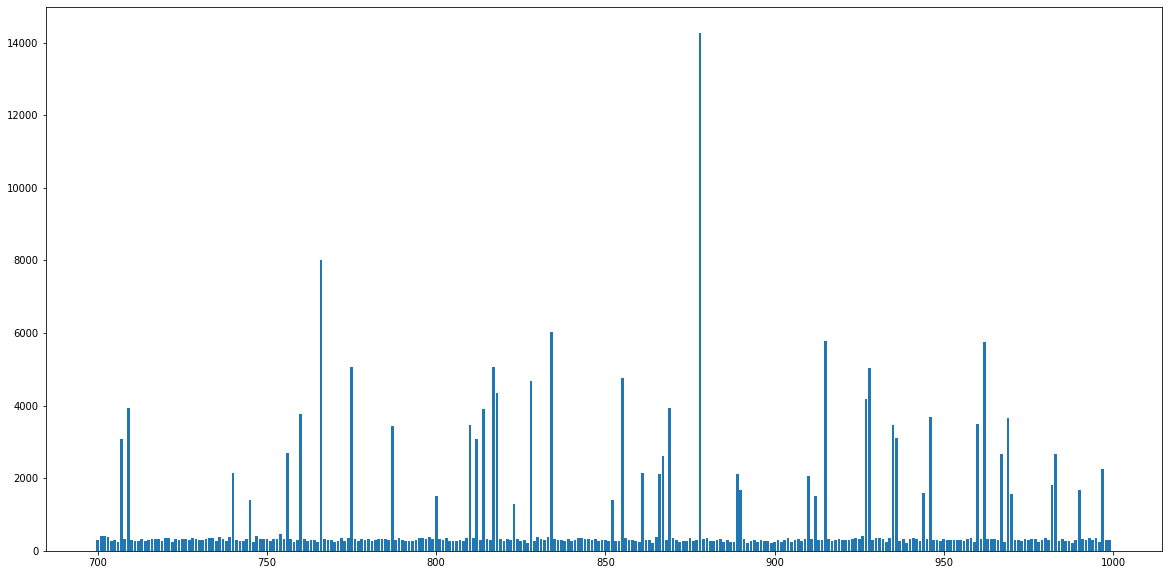

In [21]:
fig = plt.figure(figsize=(20,10))
plt.bar(subset_df['user_id'], subset_df['mean_amount'])

<BarContainer object of 35 artists>

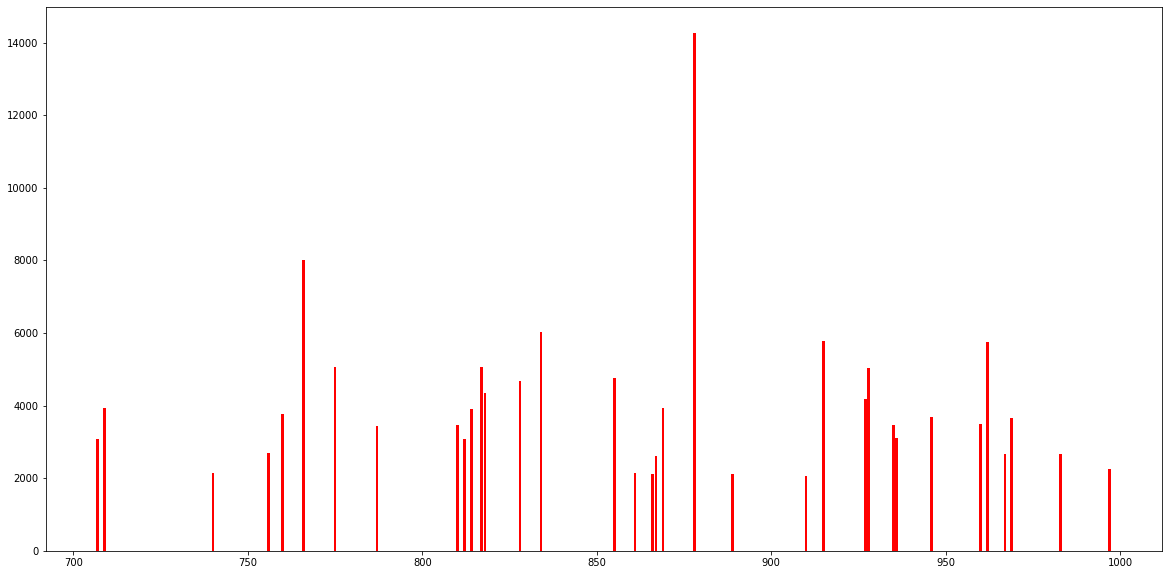

In [22]:
# plotting users with more than 2000 dollars of mean purchases
subset_df = subset_df[subset_df['mean_amount']>2000]
fig = plt.figure(figsize=(20,10))
plt.bar(subset_df['user_id'], subset_df['mean_amount'], color='red')

In [23]:
!pip install chart_studio
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable = True)
import chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot

     |████████████████████████████████| 64 kB 509 kB/s eta 0:00:01


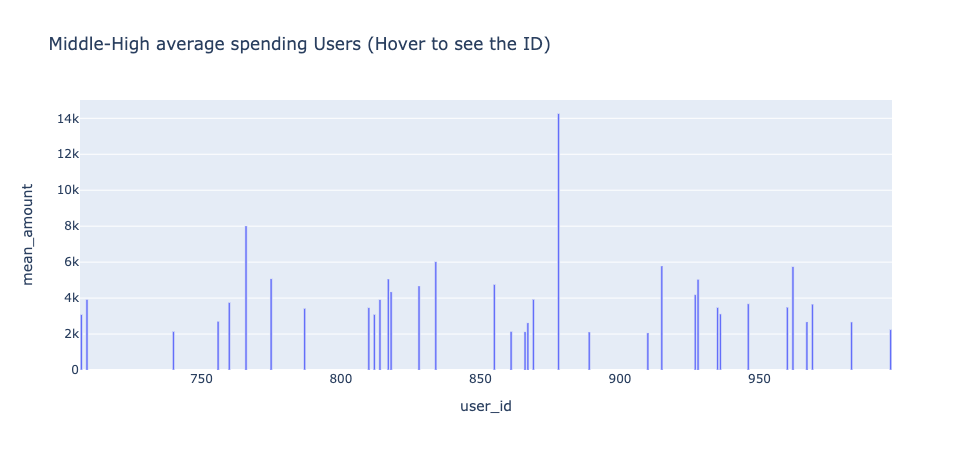

In [24]:
import plotly.express as px

px.bar(subset_df, x='user_id', y='mean_amount', title='Middle-High average spending Users (Hover to see the ID)')

In [25]:
subset_df[subset_df['user_id']==878]

,user_id,mean_amount
179,878,14266.909091


In [26]:
df[df['user_id']==878]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
691,692,78,878,154350,6,debit,2017-03-27 22:51:43
818,819,60,878,354,2,debit,2017-03-27 12:42:01
927,928,2,878,94,1,credit_card,2017-03-10 18:09:05
1575,1576,47,878,290,2,cash,2017-03-07 22:06:51
1833,1834,74,878,153,1,credit_card,2017-03-06 17:33:21
2011,2012,87,878,298,2,cash,2017-03-04 14:14:35
3474,3475,20,878,254,2,cash,2017-03-17 3:43:03
3647,3648,98,878,266,2,cash,2017-03-06 1:49:57
4106,4107,26,878,176,1,debit,2017-03-20 4:32:18
4215,4216,80,878,435,3,debit,2017-03-05 3:07:32


User 878 has a very high one time spending which is through a debit card, shop id is $78$

In [27]:
df[df['user_id']==766]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
1132,1133,81,766,354,2,cash,2017-03-07 15:43:40
1278,1279,70,766,346,2,credit_card,2017-03-15 20:05:22
1464,1465,4,766,128,1,debit,2017-03-22 23:36:53
1691,1692,84,766,459,3,debit,2017-03-09 1:39:10
2115,2116,63,766,544,4,debit,2017-03-14 17:28:31
2169,2170,4,766,256,2,debit,2017-03-20 23:10:22
2936,2937,69,766,262,2,cash,2017-03-17 22:22:59
3422,3423,20,766,381,3,cash,2017-03-30 17:36:08
3724,3725,78,766,77175,3,credit_card,2017-03-16 14:13:26
3977,3978,55,766,171,1,debit,2017-03-10 9:54:00


User 766 also has a one time high spending at shop $78$ 

In [28]:
df[df['user_id']==834]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
643,644,68,834,272,2,debit,2017-03-11 17:00:15
1218,1219,41,834,236,2,credit_card,2017-03-14 23:07:07
1619,1620,95,834,336,2,debit,2017-03-05 15:16:05
1632,1633,73,834,330,2,cash,2017-03-27 14:03:19
1720,1721,95,834,168,1,debit,2017-03-30 8:49:20
2186,2187,55,834,342,2,credit_card,2017-03-18 23:47:06
2410,2411,6,834,374,2,debit,2017-03-15 9:56:43
2492,2493,78,834,102900,4,debit,2017-03-04 4:37:34
2573,2574,20,834,127,1,credit_card,2017-03-18 3:13:16
2591,2592,79,834,543,3,credit_card,2017-03-15 5:32:35


Interestingly, user 834 also has a one time high spending using debit card at shop $78$

#### Shop 78 clearly looks suspicious

In [29]:
df[df['shop_id']==78]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
160,161,78,990,25725,1,credit_card,2017-03-12 5:56:57
490,491,78,936,51450,2,debit,2017-03-26 17:08:19
493,494,78,983,51450,2,cash,2017-03-16 21:39:35
511,512,78,967,51450,2,cash,2017-03-09 7:23:14
617,618,78,760,51450,2,cash,2017-03-18 11:18:42
691,692,78,878,154350,6,debit,2017-03-27 22:51:43
1056,1057,78,800,25725,1,debit,2017-03-15 10:16:45
1193,1194,78,944,25725,1,debit,2017-03-16 16:38:26
1204,1205,78,970,25725,1,credit_card,2017-03-17 22:32:21
1259,1260,78,775,77175,3,credit_card,2017-03-27 9:27:20


In [30]:
df_group_shop = pd.DataFrame({'mean_amount': df.groupby('shop_id')['order_amount'].mean()}).reset_index()
df_group_shop

,shop_id,mean_amount
0,1,308.818182
1,2,174.327273
2,3,305.250000
3,4,258.509804
4,5,290.311111
...,...,...
95,96,330.000000
96,97,324.000000
97,98,245.362069
98,99,339.444444


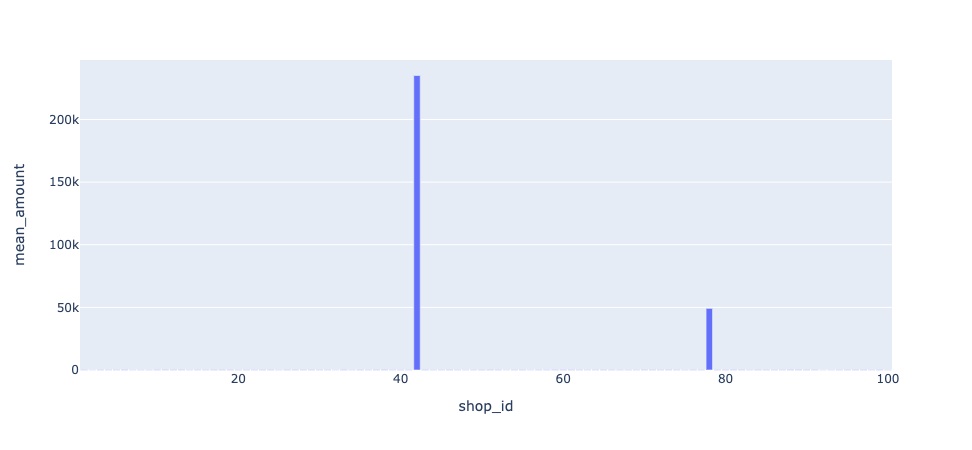

In [31]:
px.bar(df_group_shop, x='shop_id', y='mean_amount')

Wow, shop id 42 and 78 seem to be the culprit of the fraud

In [32]:
df[df['shop_id']==42]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
40,41,42,793,352,1,credit_card,2017-03-24 14:15:41
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
308,309,42,770,352,1,credit_card,2017-03-11 18:14:39
409,410,42,904,704,2,credit_card,2017-03-04 14:32:58
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
834,835,42,792,352,1,cash,2017-03-25 21:31:25
835,836,42,819,704,2,cash,2017-03-09 14:15:15
938,939,42,808,1056,3,credit_card,2017-03-13 23:43:45
979,980,42,744,352,1,debit,2017-03-12 13:09:04


## Let's remove the 2 outliers: user id 607 and shop id 78 and observe the data again

In [33]:
clean_df = df[df['user_id']!=607]
clean_df = clean_df[clean_df['shop_id']!=78]
clean_df

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11
...,...,...,...,...,...,...,...
4995,4996,73,993,330,2,debit,2017-03-30 13:47:17
4996,4997,48,789,234,2,cash,2017-03-16 20:36:16
4997,4998,56,867,351,3,cash,2017-03-19 5:42:42
4998,4999,60,825,354,2,credit_card,2017-03-16 14:51:18


In [34]:
clean_df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000
mean,2499.551347,49.846465,849.752279,302.580514,1.994734
std,1444.069407,29.061131,86.840313,160.804912,0.982821
min,1.000000,1.000000,700.000000,90.000000,1.000000
25%,1248.000000,24.000000,775.000000,163.000000,1.000000
50%,2497.000000,50.000000,850.000000,284.000000,2.000000
75%,3751.000000,74.000000,925.000000,387.000000,3.000000
max,5000.000000,100.000000,999.000000,1760.000000,8.000000


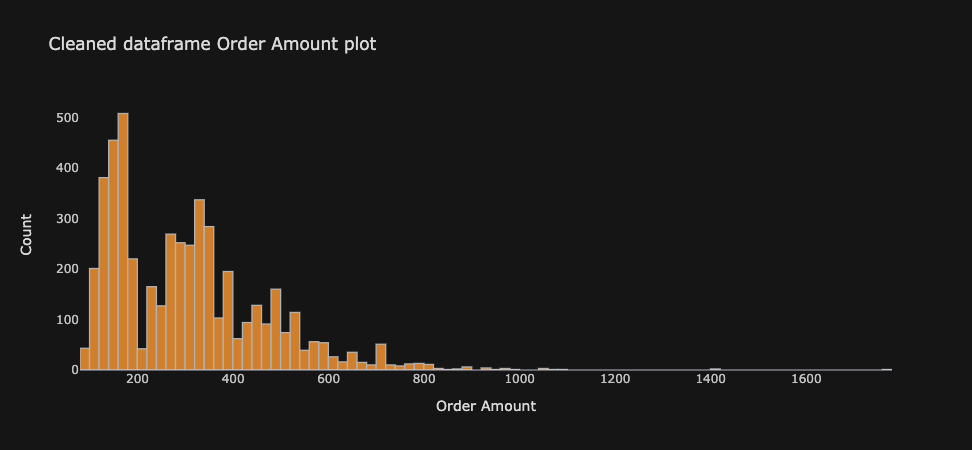

In [35]:
clean_df['order_amount'].iplot(kind='hist',
                              title='Cleaned dataframe Order Amount plot',
                              xTitle='Order Amount',
                              yTitle='Count',
                              theme='solar',
                              showgrid=False)

There still seems to be an outlier, let's explore further

<AxesSubplot:xlabel='order_amount', ylabel='Count'>

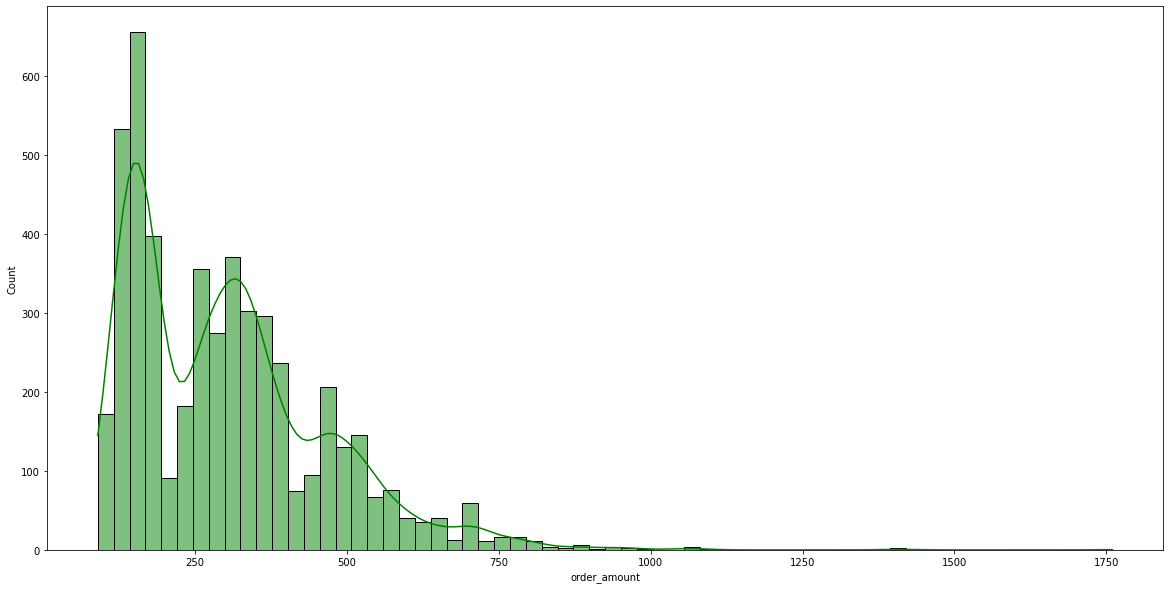

In [36]:
fig = plt.figure(figsize=(20,10))
sns.histplot(clean_df['order_amount'], color='green', kde=True)

<BarContainer object of 4937 artists>

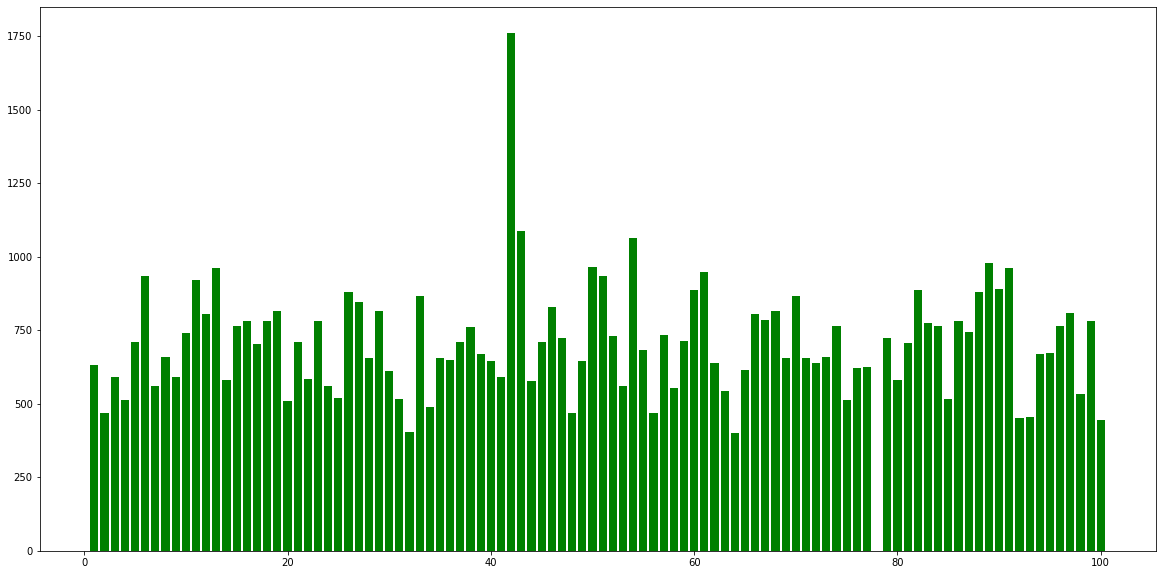

In [37]:
fig = plt.figure(figsize=(20,10))
plt.bar(clean_df['shop_id'], clean_df['order_amount'], color='#008000')

In [38]:
clean_df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


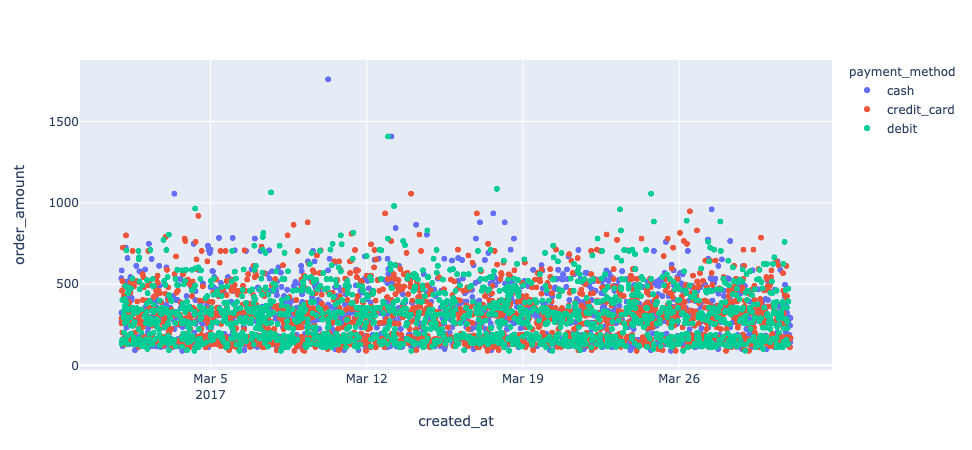

In [40]:
px.scatter(clean_df, x='created_at', y='order_amount', color='payment_method')

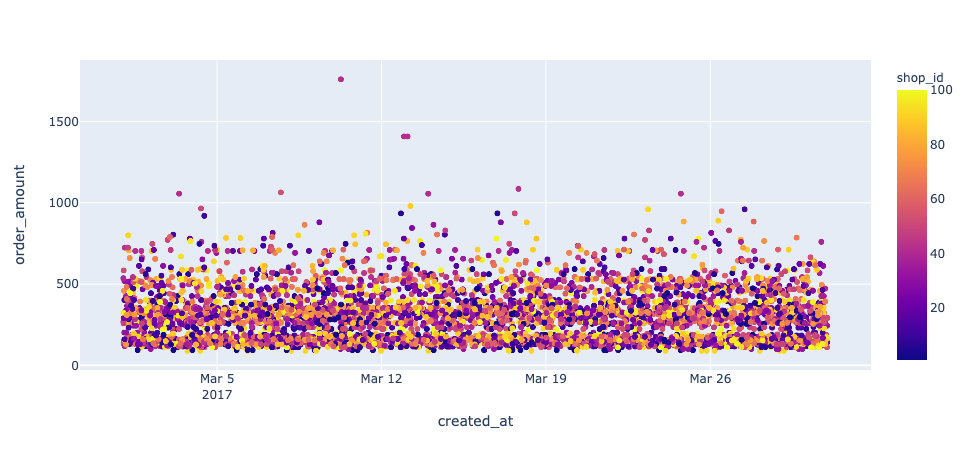

In [41]:
px.scatter(clean_df, x='created_at', y='order_amount', color='shop_id')

In [42]:
clean_df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000
mean,2499.551347,49.846465,849.752279,302.580514,1.994734
std,1444.069407,29.061131,86.840313,160.804912,0.982821
min,1.000000,1.000000,700.000000,90.000000,1.000000
25%,1248.000000,24.000000,775.000000,163.000000,1.000000
50%,2497.000000,50.000000,850.000000,284.000000,2.000000
75%,3751.000000,74.000000,925.000000,387.000000,3.000000
max,5000.000000,100.000000,999.000000,1760.000000,8.000000


## Conclusion - Answer to Question 1:

1. There are no missing values
2. There are no duplicates
3. There are 2 outliers: user id 607 and shop id 78 : These 2 are the main reasons of fraud
4. Net mean of the cleaned (with no outliers) data is $302.58 $$
5. Here median (284) could also be used but after removing outliers, mean is a better representative of the spread

#### Please view the notebook in NBviewer to see all the plotly graphs of this notebook

## Question 2

#### Q1. How many orders were shipped by Speedy Express in total?

<br> SELECT Count(OrderID) FROM
<br> Orders o Inner Join Shippers s
<br> ON o.ShipperID = s.ShipperID
<br> Where ShipperName = 'Speedy Express'

<br> <b> Answer: 54 </b>

#### Q2. What is the last name of the employee with the most orders?

<br> SELECT LastName, MAX(NetOrders) FROM
<br> (Select *, COUNT(DISTINCT OrderID) as NetOrders FROM
<br> (SELECT o.OrderID, e.EmployeeID, e.LastName, e.FirstName
<br> FROM Orders o Inner Join Employees e
<br> ON o.EmployeeID = e.EmployeeID)
<br> GROUP BY EmployeeID
<br> ORDER BY COUNT(DISTINCT OrderID) DESC)


<br> <b> Answer: Peacock (number of orders are 40) </b>

#### Q3. What product was ordered the most by customers in Germany?

<br> SELECT ProductName, MaxOrders FROM
<br> (SELECT ProductID, MAX(NetOrders) as MaxOrders FROM
<br> (Select *, Count(DISTINCT OrderID) AS NetOrders from 
<br> (SELECT *
<br> From Orders o Inner Join OrderDetails od
<br> On o.OrderID = od.OrderID
<br> Where CustomerID IN
<br> (Select CustomerID From
<br> Customers Where Country = 'Germany'))
<br> Group by ProductID
<br> Order by COUNT(DISTINCT OrderID) DESC)) t1 Inner Join Products p
<br> WHERE t1.ProductID = p.ProductID



<br> <b> Answer: Gorgonzola Telino (number of orders are 5) </b>